In [136]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# reading the data into variable called name
import csv

names = []
with open('arabic_names.csv', 'r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        names.append(row[0])

names.pop(0)
print(f"The length of names is {len(names)}")
print(f"The first 5 names are {names[:5]}")

The length of names is 1405
The first 5 names are ['ابتسام', 'ابتهاج', 'ابتهال', 'اجتهاد', 'ازدهار']


In [11]:
# Randomizing the data set
random.seed(56)
random.shuffle(names)

n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))
print(f"the data set have {len(names)}, {n1=}, {n2=}")

the data set have 1405, n1=1124, n2=1264


In [12]:
# converting characters to number
chars = sorted(list(set(''.join(names))))
chars.insert(0, '.')

# create character to integer
ctoi = {value: index for index, value in enumerate(chars)}

# create integer to character
itoc = {value: index for index, value in ctoi.items()}

In [13]:
ctoi

{'.': 0,
 ' ': 1,
 'ء': 2,
 'آ': 3,
 'أ': 4,
 'ؤ': 5,
 'إ': 6,
 'ئ': 7,
 'ا': 8,
 'ب': 9,
 'ة': 10,
 'ت': 11,
 'ث': 12,
 'ج': 13,
 'ح': 14,
 'خ': 15,
 'د': 16,
 'ذ': 17,
 'ر': 18,
 'ز': 19,
 'س': 20,
 'ش': 21,
 'ص': 22,
 'ض': 23,
 'ط': 24,
 'ظ': 25,
 'ع': 26,
 'غ': 27,
 'ف': 28,
 'ق': 29,
 'ك': 30,
 'ل': 31,
 'م': 32,
 'ن': 33,
 'ه': 34,
 'و': 35,
 'ى': 36,
 'ي': 37}

In [14]:
# preparing the dataset and split them into training, dev, and test samples.
# we need the first one to be ., ., . --> ا

# define a function build_dataset to accept list of names and output them in X, Y format

def build_dataset(names):
    X, Y = [], []
    block_size = 3

    for name in names:
        context = [0] * block_size

        for cha in name + '.':
            X.append(context)
            ix = ctoi[cha]
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)


    return X, Y



In [15]:
Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xtest , Ytest = build_dataset(names[n2:])

In [16]:
print(f"{Xtr.shape=} {Ytr.shape=}, and {Xdev.shape=}, and {Xtest.shape=}")

Xtr.shape=torch.Size([6135, 3]) Ytr.shape=torch.Size([6135]), and Xdev.shape=torch.Size([750, 3]), and Xtest.shape=torch.Size([761, 3])


In [149]:
# define a gnerator
g = torch.Generator().manual_seed(123456789)

n_emb = 10  # The dimentions of the embedding space
n_hidden = 10 # number of neurones in the hidden layer
# creating the embedded layer to embed our 38 character in 2D arrya and the first layer
len(chars) # == 38
C = torch.randn((len(chars), 2))
# Creating the hidden layer
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

W2 = torch.randn((100, 38))
b2 = torch.randn(38)

parameters = [C, W1, W2, b1, b2]

In [150]:
for p in parameters:
    p.requires_grad = True

In [170]:
for _ in range(5000):
    # making mini-patches
    random_numbers = torch.randint(0, Xtr.shape[0], (100,))

    # forward pass
    emb = C[Xtr[random_numbers]]  # we're impeding the char in 2D array =>
    # print(f"The embed shape is {emb.shape=}") # (number of rows in X, number of columns in X, the crosponding vector from C to this number)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    # print(f"The hidden layer shape is {h.shape=}")
    logits = h @ W2 + b2
    # print(f"The Logits layer shape is {logits.shape=}, and Y shape is {Ysmall.shape=}")
    loss = F.cross_entropy(logits, Ytr[random_numbers])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()


    # update
    for p in parameters:
        p.data += -0.05 * p.grad

print(loss)

tensor(1.9966, grad_fn=<NllLossBackward0>)


In [172]:
# calculate the loss in the entire dataset

emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(f"The total lost is {loss=}")

The total lost is loss=tensor(2.5023, grad_fn=<NllLossBackward0>)


In [175]:
emb = C[Xtest]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytext)
print(f"The total lost is {loss=}")

The total lost is loss=tensor(2.5869, grad_fn=<NllLossBackward0>)


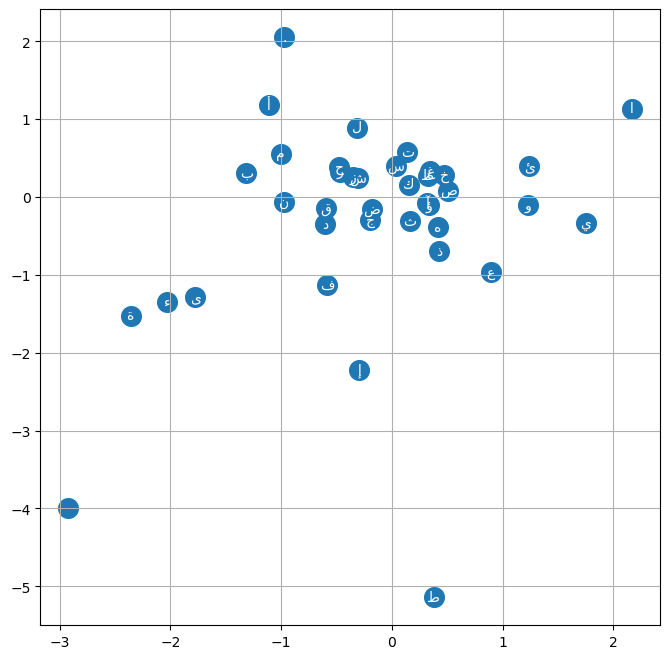

In [176]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itoc[i], ha="center", va="center", color='white')
plt.grid('minor')

In [177]:
# ٍSampling from the model
for _ in range(10):
    block_size = 3
    context = [0] * block_size
    out = []

    while True:
        emb = C[context]
        h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        out.append(ix)
        context = context[1:] + [ix]
        if ix == 0:
            break;

    print("".join(itoc[i] for i in out))

شدة.
عقيد.
باف.
تدع.
جهيمى.
تور.
تضيم.
عبدالحنيسة.
يند.
يبدالوهي.
ميمة.
لين.
عد.
كزيح.
عبدالب.
بضير.
توهاب.
أوضبة.
فدصلم.
كلأ.
